In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import data

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
torch.manual_seed(441)

In [3]:
class Data(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()

        # X_train_data = read_csv('../X_train_nostring.csv')
        # X_train_data.fillna(-3, inplace=True)

        # self.X_train = X_train_data.values[:,1:]

        y_train_data = read_csv('../y_train.csv')
        self.y_train = y_train_data.values[:,1]
        for i in range(len(self.y_train)):
            if self.y_train[i] == -1:
                self.y_train[i] = 0

        #xgb: v30c, c_abrv_GE, v275b_N2_AZ-GYG, v281a_ka, v275b_N2_GE02, v275b_N2_AZ-SAT, v3, v281a_az, c_abrv_DK, c_abrv_CH, v281a_sr, v147
        #forest: v60, v53, v154, v59, v55, v277 (big), v158, v156, v282 (big), v261_ppp, v155, v58
        
        #xgb importance
        # cols = ['v147', 'v281a_sr', 'c_abrv_CH', 'c_abrv_DK', 'v281a_az', 'v62', 'v3', 'v275b_N2_AZ-SAT', 'v275b_N2_GE02', 'v281a_ka', 'v52_cs', 'v196', 'v52', 'v275b_N2_AZ-GYG', 'c_abrv_GE', 
        #         'v30c', 'v5', 'v115','v51', 'v57', 'v54', 'v64', 'v56', 'v93', 'v63']

        #random forest importance only change is v275c_N2 -> v58
        # cols = ['v58', 'v155', 'v261_ppp', 'v196', 'v282', 'v156', 'v158', 'v277', 'v55', 'v59', 'v154', 'v5', 'v93', 'v53', 'v51', 'v60', 'v52', 'v62', 
        #         'v52_cs', 'v115', 'v57', 'v56', 'v54', 'v64', 'v63']

        #intersection
        cols  = ['v196', 'v5', 'v63', 'v52', 'v57', 'v51', 'v115', 'v93', 'v56', 'v54', 'v62', 'v64']

        #merge
        # cols = ['v5', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v59', 'v60', 'v62', 'v63', 'v64', 'v93', 'v115', 'v147', 'v154', 'v156', 'v158', 'v196']

        scaler =  MinMaxScaler(feature_range=(-1, 1))
        self.ds = data.Dataset()

        
        X_train_temp = self.ds.getTrain().loc[:, cols].values
        # X_train_temp = X_train_data.loc[:, cols].values
        scaled = scaler.fit_transform( X_train_temp )
        
        X_train, X_val, y_train, y_val = train_test_split(scaled, self.y_train, test_size=0.25, random_state=441)


        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        
        self.X_test = scaler.fit_transform( self.ds.getTest().loc[:, cols].values )

        # X_test_data = read_csv('../X_test_nostring.csv')
        # X_test_data.fillna(-3, inplace=True)
        # self.X_test = X_test_data.loc[:, cols].values

        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.X_train[idx], dtype=torch.float32)
        y = self.y_train[idx]
        return x, y

In [4]:
ds = Data()
ds.X_train.shape

(36000, 12)

In [5]:
# Batched, for training
batch_size_train = 36000
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=False)

In [6]:
net = nn.Sequential(
    nn.BatchNorm1d(ds.X_train.shape[1]),
    nn.Linear(ds.X_train.shape[1], 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.BatchNorm1d(8),
    nn.ReLU(),
    nn.Linear(8, 5),
    nn.Softmax(dim=1)
)

net.to(device)

Sequential(
  (0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=12, out_features=16, bias=True)
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=8, out_features=5, bias=True)
  (8): Softmax(dim=1)
)

In [7]:
# Train it
loss_fcn = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

def train(net, dl, epochs=100):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data in dl:
            x, t = data
            y = net(x.to(device))

            loss = loss_fcn(y, t.to(device))
            epoch_loss += loss.item()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        epoch_loss /= len(dl)
        losses.append(epoch_loss)
    
    plt.figure(figsize=(4,4))
    plt.plot(losses);
    
    return losses[-1]


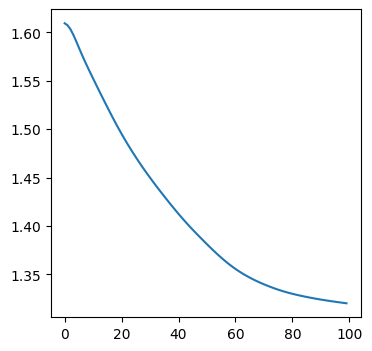

In [8]:
last = train(net, train_dl, 100)

In [9]:
print(last)

1.320102334022522


25 importance 100 epoch 

1.29 1.37 whole batch xgb cols 

1.3 1.37 whole batch forest no change cols

25 importance merged (25 -> 128 -> 32 -> 5)

1.29 1.38 

1.33 1.44 (dropout)


In [10]:
X_val = ds.X_val
y_val = ds.y_val

val = net( torch.tensor(X_val, dtype=torch.float).to(device) ).cpu().detach().numpy()
val_score = log_loss(y_val, val)

In [11]:
print(val_score)

1.3487295969861377


In [12]:
X_test = ds.X_test

prob = net( torch.tensor(X_test, dtype=torch.float).to(device) ).cpu().detach().numpy()

In [13]:
test = np.c_[ np.ones(11438), prob ]              # add a column

for i in range(len(test)):
    test[i][0] = i

np.savetxt('neural_net.csv', test, delimiter=',', header="id,no answer,very important,quite important,not important,not at all important", comments="", fmt='%1.4f') 